In [3]:
import sys
sys.path.insert(0, "../..")

In [4]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor,Compose
from torch.utils.data import DataLoader

In [12]:
dataset_train = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
dataset_test = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

train_dataloader = DataLoader(dataset_train, batch_size=128, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=128, shuffle=True)

X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

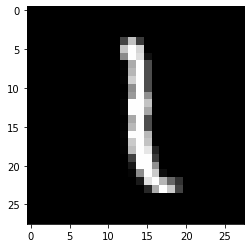

In [13]:
import matplotlib.pyplot as plt
img = X[0]
img.shape
plt.imshow(img.squeeze(), cmap="gray")

In [27]:
from torch import nn

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()

        self.conv_layers = nn.Sequential(
                    nn.Conv2d(1, 10, kernel_size=5),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                    nn.Conv2d(10, 20, kernel_size=5),
                    nn.Dropout(),
                    nn.MaxPool2d(2),
                    nn.ReLU(),
                )

        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        out = self.fc_layers(x)
        return out

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_layers): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): Dropout(p=0.5, inplace=False)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)


In [29]:
import torch.optim as optim
from src.models import metrics
from src.models import train_model
from pathlib import Path

loss_fn = torch.nn.CrossEntropyLoss()
accuracy = metrics.Accuracy()

log_dir="../../models/test"


model = train_model.trainloop(
    epochs=10,
    model=model,
    optimizer=optim.Adam,
    learning_rate=1e-2,
    loss_fn=loss_fn,
    metrics=[accuracy],
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    log_dir=log_dir,
    train_steps=50,
    eval_steps=50,
)



2023-01-04 13:21:03.143 | INFO     | src.data.data_tools:dir_add_timestamp:228 - Logging to ../../models/test/20230104-1321
100%|██████████| 50/50 [00:01<00:00, 27.01it/s]
2023-01-04 13:21:06.244 | INFO     | src.models.train_model:trainloop:171 - Epoch 0 train 1.7153 test 1.6166 metric ['0.8442']
100%|██████████| 50/50 [00:01<00:00, 30.60it/s]
2023-01-04 13:21:08.726 | INFO     | src.models.train_model:trainloop:171 - Epoch 1 train 1.6675 test 1.5942 metric ['0.8670']
100%|██████████| 50/50 [00:01<00:00, 25.41it/s]
2023-01-04 13:21:11.642 | INFO     | src.models.train_model:trainloop:171 - Epoch 2 train 1.6581 test 1.6160 metric ['0.8438']
100%|██████████| 50/50 [00:01<00:00, 28.30it/s]
2023-01-04 13:21:14.259 | INFO     | src.models.train_model:trainloop:171 - Epoch 3 train 1.6640 test 1.5968 metric ['0.8631']
100%|██████████| 50/50 [00:01<00:00, 28.89it/s]
2023-01-04 13:21:17.112 | INFO     | src.models.train_model:trainloop:171 - Epoch 4 train 1.6420 test 1.5287 metric ['0.9328']
1

In [30]:
model_dir = Path("../../models") 
modelpath = model_dir / "trained_model"
torch.save(model, modelpath)



Now we have our model, we can start making our explainer. This explainer will show why a certain number was classified as it is.

In [36]:
import shap
import numpy as np

# since shuffle=True, this is a random sample of test data
batch = next(iter(test_dataloader))
images, _ = batch

background = images[:100]

#use the 5 next images as the ones to be explained
test_images = images[100:105]

#create the explainer using shap.DeepExplainer
explainer = shap.DeepExplainer(model, background)


shap_values = explainer.shap_values(test_images)

In [37]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

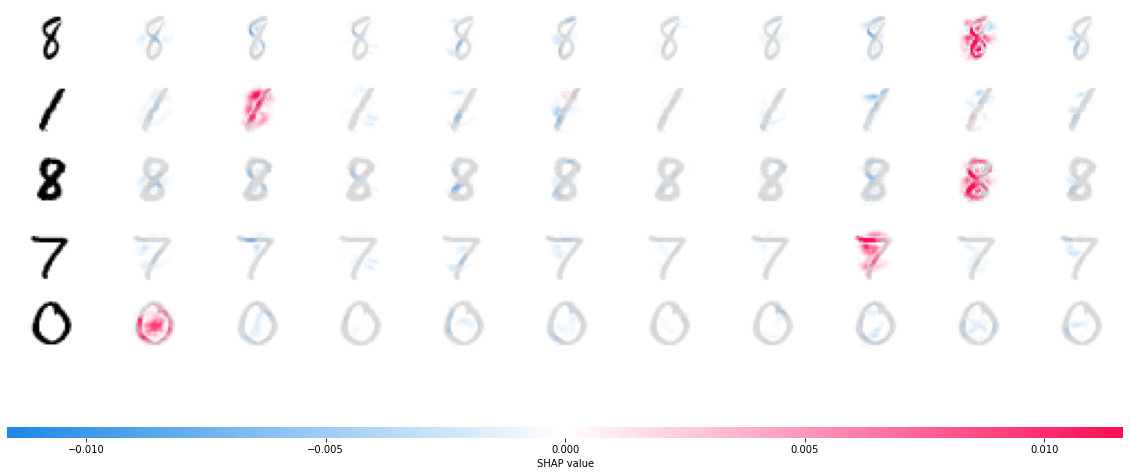

In [38]:
# plot the feature attributions
shap.image_plot(shap_numpy, -test_numpy)